<a href="https://colab.research.google.com/github/ShepherdCode/ShepherdML/blob/master/Nasa2021/MLP_403.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP 403


In [49]:
NC_FILENAME='ncRNA.gc34.processed.fasta'
PC_FILENAME='pcRNA.gc34.processed.fasta'
MODEL_FILE='MLP305.model'   # will save!
DATAPATH=''

try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
except:
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
NC_FILENAME = DATAPATH+NC_FILENAME
PC_FILENAME = DATAPATH+PC_FILENAME
MODEL_FILE=DATAPATH+MODEL_FILE

EPOCHS=200   # how many times to train on the entire data set per vaidation
SPLITS=5     # how many cross validations to run
K=3          # size of the k-mer
VOCABULARY_SIZE=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
EMBED_DIMEN=16
NEURONS=16

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Load tools module

In [50]:
GITHUB = True   # set to False if testing your own local tools file 
if GITHUB:
    #!pip install requests  # Uncomment this if necessary. Seems to be pre-installed.
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/ShepherdML/master/Strings/tools_fasta.py')
    with open('tools_fasta.py', 'w') as f:
        f.write(r.text)
    # TO DO: delete the file after import
import tools_fasta as tools
tools.yahoo()  # If this prints "Yahoo!" the the import was successful.

TOOLS_CHANGED = False   # set to True if you recently commit a revision to github
if TOOLS_CHANGED:
  from importlib import reload 
  tools=reload(tools)
  print(dir(tools))   # run this to see EVERYTHING in the tools module

Yahoo!


In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import LayerNormalization
import time
dt='float32'
tf.keras.backend.set_floatx(dt)

Build model

In [52]:
def compile_model(model):
    adam_default_learn_rate = 0.001
    schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = adam_default_learn_rate*10,
        #decay_steps=100000, decay_rate=0.96, staircase=True)
        decay_steps=100000, decay_rate=0.99, staircase=True)
    # learn rate = initial_learning_rate * decay_rate ^ (step / decay_steps)
    opt = tf.keras.optimizers.Adam(learning_rate=schedule)
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    model.compile(loss=bc, optimizer=opt, metrics=["accuracy"])
    print("...COMPILED")
    return model

def build_model(maxlen):
    act="elu"
    #embed_layer  = keras.layers.Embedding(
    #    VOCABULARY_SIZE,EMBED_DIMEN,input_length=maxlen);
    #dropout1_layer = keras.layers.Dropout(0.2)
    dropout2_layer = keras.layers.Dropout(0.4)
    dropout3_layer = keras.layers.Dropout(0.4)
    dense1_layer = keras.layers.Dense(64, activation=act,dtype=dt,
                                      input_dim=VOCABULARY_SIZE)
    dense2_layer = keras.layers.Dense(32, activation=act,dtype=dt)
    #dense3_layer = keras.layers.Dense(NEURONS, activation=act,dtype=dt)
    output_layer = keras.layers.Dense(1,  activation="sigmoid",dtype=dt)
    mlp = keras.models.Sequential()
    #mlp.add(dropout1_layer)
    #mlp.add(embed_layer)
    mlp.add(dense1_layer)
    mlp.add(dropout2_layer)
    mlp.add(dense2_layer)
    mlp.add(dropout3_layer)
    #mlp.add(dense3_layer)
    mlp.add(output_layer)
    mlpc = compile_model(mlp)
    return mlpc

In [53]:
def make_slice(data_set,min_len,max_len):
    slice = data_set.query('seqlen <= '+str(max_len)+' & seqlen>= '+str(min_len))
    return slice

## Cross validation

In [54]:
def do_cross_validation(X,y,given_model):
    cv_scores = []
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.1, random_state=37863)
    for train_index,valid_index in splitter.split(X):
        fold += 1
        X_train=X[train_index] # use iloc[] for dataframe
        y_train=y[train_index]
        X_valid=X[valid_index]
        y_valid=y[valid_index]        
        # Avoid continually improving the same model.
        model = compile_model(keras.models.clone_model(given_model))
        bestname=MODEL_FILE+".cv."+str(fold)+".best"
        mycallbacks = [keras.callbacks.ModelCheckpoint(
            filepath=bestname, save_best_only=True, 
            monitor='val_accuracy', mode='max')]   
        print("FIT")
        start_time=time.time()
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                callbacks=mycallbacks,
                validation_data=(X_valid,y_valid) )
        end_time=time.time()
        elapsed_time=(end_time-start_time)                        
        print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()
        best_model=keras.models.load_model(bestname)
        scores = best_model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)  
    print()
    print("%d-way Cross Validation mean %.2f%% (+/- %.2f%%)" % (fold, np.mean(cv_scores), np.std(cv_scores)))

## Train on RNA lengths 200-1Kb

In [55]:
MINLEN=200
MAXLEN=1000
print("Load data from files.")
nc_seq=tools.load_fasta(NC_FILENAME,0)
pc_seq=tools.load_fasta(PC_FILENAME,1)
train_set=pd.concat((nc_seq,pc_seq),axis=0)
nc_seq=None
pc_seq=None
print("Ready: train_set")
print ("Data prep")
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y
print ("Data reshape")
(X_train,y_train)=tools.make_kmers(K,MAXLEN,subset)
X_train=tools.make_frequencies(K,X_train)
print("Ready")

Load data from files.
Ready: train_set
Data prep
Data reshape
Ready


Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 64)                4224      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 33        
Total params: 6,337
Trainable params: 6,337
Non-trainable params: 0
_________________________________________________________________
None
INFO:tensorflow:Assets written to: /content/drive/My

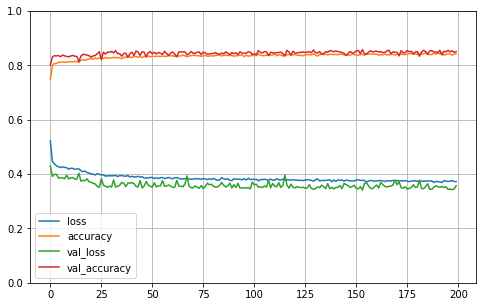

accuracy: 85.79%
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 2s 3ms/step - loss: 0.5549 - accuracy: 0.7203 - val_loss: 0.4555 - val_accuracy: 0.7958
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/MLP305.model.cv.2.best/assets
Epoch 2/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4522 - accuracy: 0.7999 - val_loss: 0.4751 - val_accuracy: 0.7827
Epoch 3/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4382 - accuracy: 0.8062 - val_loss: 0.4262 - val_accuracy: 0.8169
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/MLP305.model.cv.2.best/assets
Epoch 4/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4280 - accuracy: 0.8080 - val_loss: 0.4766 - val_accuracy: 0.7753
Epoch 5/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4299 - accuracy: 0.8110 - val_loss: 0.4394 - val_accuracy: 0.8063
Epoch 6/200
453/453 [==============================] 

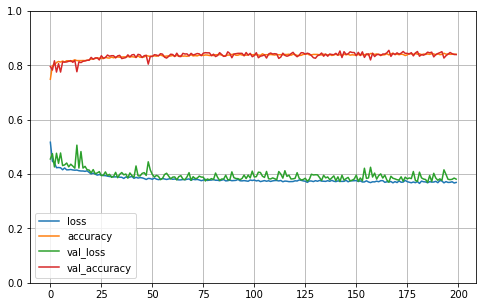

accuracy: 85.54%
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 2s 3ms/step - loss: 0.5481 - accuracy: 0.7268 - val_loss: 0.4297 - val_accuracy: 0.8070
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/MLP305.model.cv.3.best/assets
Epoch 2/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4443 - accuracy: 0.7980 - val_loss: 0.4154 - val_accuracy: 0.8169
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/MLP305.model.cv.3.best/assets
Epoch 3/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4346 - accuracy: 0.8096 - val_loss: 0.4037 - val_accuracy: 0.8305
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/MLP305.model.cv.3.best/assets
Epoch 4/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4305 - accuracy: 0.8063 - val_loss: 0.4045 - val_accuracy: 0.8293
Epoch 5/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4230 - accuracy: 0.8108 -

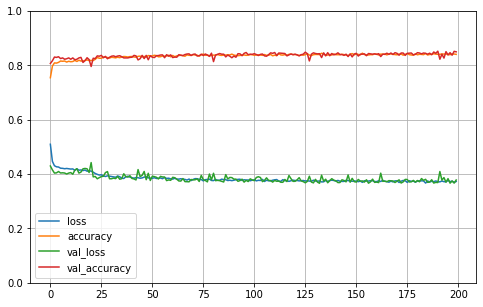

accuracy: 85.23%
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 2s 3ms/step - loss: 0.5492 - accuracy: 0.7246 - val_loss: 0.4271 - val_accuracy: 0.8051
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/MLP305.model.cv.4.best/assets
Epoch 2/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4410 - accuracy: 0.8019 - val_loss: 0.4258 - val_accuracy: 0.8026
Epoch 3/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4345 - accuracy: 0.8070 - val_loss: 0.4114 - val_accuracy: 0.8156
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/MLP305.model.cv.4.best/assets
Epoch 4/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4198 - accuracy: 0.8187 - val_loss: 0.4689 - val_accuracy: 0.7703
Epoch 5/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4339 - accuracy: 0.8088 - val_loss: 0.4173 - val_accuracy: 0.8070
Epoch 6/200
453/453 [==============================] 

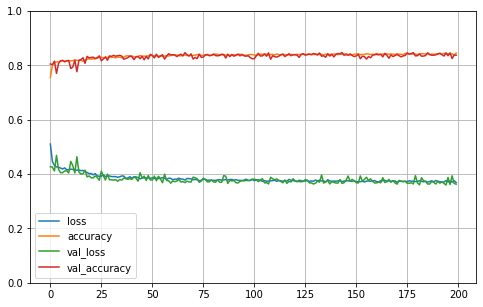

accuracy: 84.73%
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 2s 3ms/step - loss: 0.5561 - accuracy: 0.7206 - val_loss: 0.4108 - val_accuracy: 0.8163
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/MLP305.model.cv.5.best/assets
Epoch 2/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4519 - accuracy: 0.7941 - val_loss: 0.4436 - val_accuracy: 0.7970
Epoch 3/200
453/453 [==============================] - 1s 2ms/step - loss: 0.4403 - accuracy: 0.7996 - val_loss: 0.3909 - val_accuracy: 0.8237
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/MLP305.model.cv.5.best/assets
Epoch 4/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4274 - accuracy: 0.8066 - val_loss: 0.4268 - val_accuracy: 0.8101
Epoch 5/200
453/453 [==============================] - 1s 3ms/step - loss: 0.4289 - accuracy: 0.8075 - val_loss: 0.4000 - val_accuracy: 0.8206
Epoch 6/200
453/453 [==============================] 

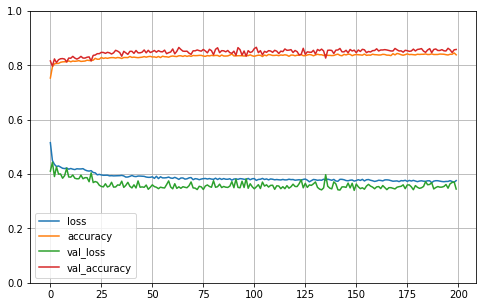

accuracy: 86.65%

5-way Cross Validation mean 85.59% (+/- 0.64%)
Done


In [56]:
print ("Compile the model")
model=build_model(MAXLEN)
print ("Summarize the model")
print(model.summary())  # Print this only once
model.save(MODEL_FILE)

print ("Cross valiation")
do_cross_validation(X_train,y_train,model)  
print ("Done")